In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install python-gdcm
!pip install pylibjpeg[all]

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.9 MB/s eta 0:00:00
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.3/969.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.4 MB/s eta 0:00:00


In [3]:
import pydicom
from PIL import Image
import cv2
import shutil
import matplotlib.pyplot as plt

Read csv into DataFrame.

In [4]:
img_folder = "/kaggle/input/rsna-breast-cancer-detection/"

df = pd.read_csv(img_folder + "train.csv")

In [5]:
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Take one image as an example.

In [6]:
image_id = 1316137804
patient_id = df.loc[df['image_id']==image_id, 'patient_id'].to_numpy()[0]
print(patient_id, image_id)

31460 1316137804


In [7]:
def get_path(patient_id, image_id):
    return os.path.join(img_folder, "train_images", str(patient_id), str(image_id) + ".dcm")

In [8]:
img = pydicom.dcmread(get_path(patient_id, image_id))
img_arr = img.pixel_array
print(img_arr.shape)
print(img_arr.min(), img_arr.max())

(5355, 4915)
646 4052


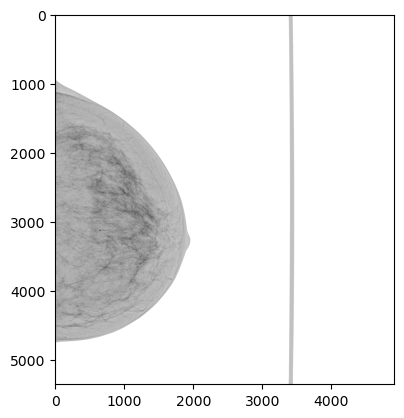

In [9]:
plt.imshow(img_arr, cmap='gray')
plt.show()

This image has a lot of background area, which does not have much information. It needs to be cropped.

Create a function to rescale the pixel values from 0 to 255. It also inverts the images if the background is not 0.

In [10]:

def rescale_pixels(dcm_img_arr):
    if not isinstance(dcm_img_arr, np.ndarray):
        dcm_img_arr = np.array(dcm_img_arr)
    gray_img = (dcm_img_arr - dcm_img_arr.min()) / (dcm_img_arr.max() - dcm_img_arr.min()) * 255
    gray_img = np.uint8(gray_img)
    height, width = gray_img.shape
    total_pixels = height * width
    count_255 = np.sum((gray_img == 255).astype(int))
    if count_255/total_pixels > 0.2:
        gray_img = 255 -  gray_img
    return gray_img

In [11]:
# this is a helper function to find the area of the images to crop
def longest_block(arr):
    prev_pt = -1
    curr_pt = 0
    blocks = []
    start = end = -1
    while curr_pt < len(arr):
        if arr[curr_pt] == 1:
            if prev_pt != -1 and arr[prev_pt] == 1:
                end = curr_pt
            else:
                start = end = curr_pt
        else:
            if prev_pt != -1 and arr[prev_pt] == 1:
                blocks.append((start, end+1))
                
        curr_pt += 1
        prev_pt += 1
    if arr[prev_pt] == 1:
        blocks.append((start, end+1))
    return sorted(blocks, key=lambda x: x[1]-x[0])[-1]

In [12]:
def crop_image(img_arr, crop_threshold = 0.05, margin=0):
    if not isinstance(img_arr, np.ndarray):
        img_arr = np.array(img_arr)
    col_sum = img_arr.sum(axis=0)
    row_sum = img_arr.sum(axis=1)
    col_valid = (col_sum > col_sum.max() * crop_threshold).astype(int)
    row_valid = (row_sum > row_sum.max() * crop_threshold).astype(int)
    col_lo, col_hi = longest_block(col_valid)
    row_lo, row_hi = longest_block(row_valid)
    h, w = img_arr.shape
    col_lo = max(0, col_lo - margin)
    col_hi = min(w, col_hi + margin)
    row_lo = max(0, row_lo - margin)
    row_hi = min(h, row_hi + margin)
    cropped_img = np.zeros((row_hi - row_lo, col_hi - col_lo))
    cropped_img[:,:] = img_arr[row_lo:row_hi, col_lo:col_hi]
    return np.uint8(cropped_img)

### compare different resolutions. 

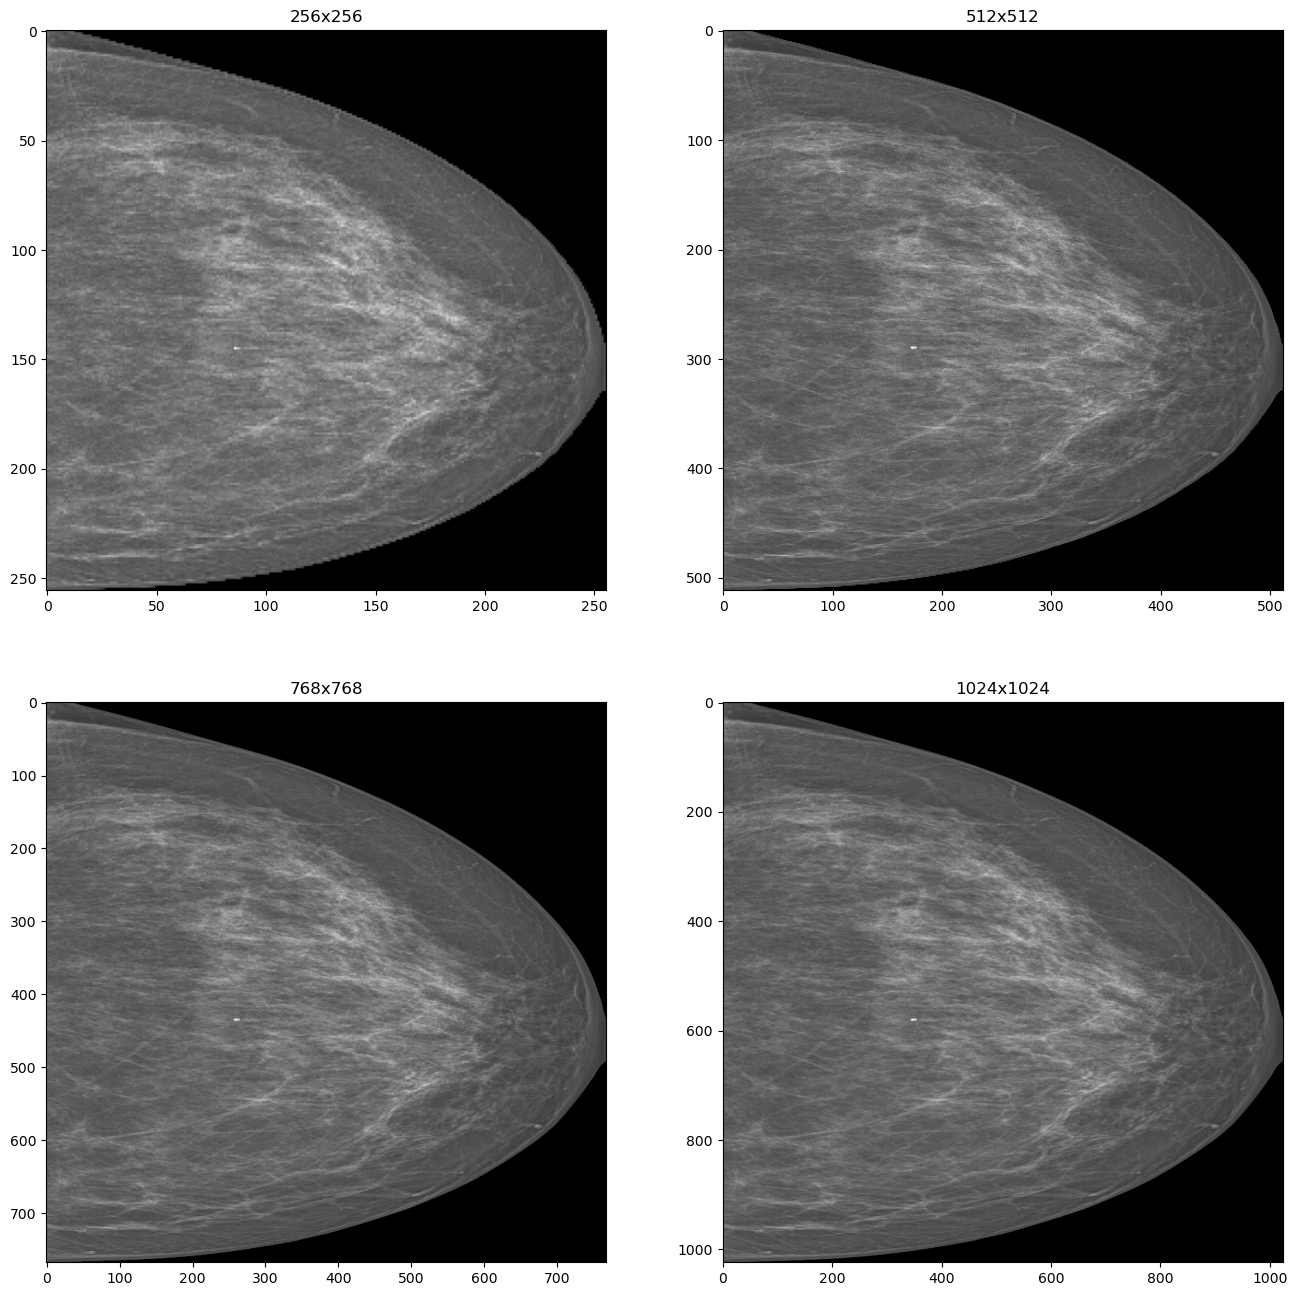

In [13]:
img_arr3 = rescale_pixels(img_arr)
img_arr4 = crop_image(img_arr3)
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.imshow(cv2.resize(img_arr4, (256, 256)), cmap='gray')
plt.title("256x256")
plt.subplot(2,2,2)
plt.imshow(cv2.resize(img_arr4, (512, 512)), cmap='gray')
plt.title("512x512")
plt.subplot(2,2,3)
plt.imshow(cv2.resize(img_arr4, (768, 768)), cmap='gray')
plt.title("768x768")
plt.subplot(2,2,4)
plt.imshow(cv2.resize(img_arr4, (1024, 1024)), cmap='gray')
plt.title("1024x1024")
plt.show()

The 256x256 image does loss some details

### Process the DCM images

In [14]:
train_image_folder = "/kaggle/working/train_images_jpg1024"
if not os.path.exists(train_image_folder):
    os.mkdir(train_image_folder)

In [15]:
def process_image(patient_id, image_id, output_shape=(1024, 1024)):
    dcm_img = pydicom.dcmread(get_path(patient_id, image_id))
    img_arr = dcm_img.pixel_array
    # rescale pixels from 0 to 255. Also inverse pixels to make backgroud zero
    img_arr = rescale_pixels(img_arr)
    # crop images
    img_arr = crop_image(img_arr)
    # resize images to 1024x1024
    img_arr = cv2.resize(img_arr, output_shape).astype('uint8')
    
    output_folder = os.path.join(train_image_folder, str(patient_id))
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    new_img = Image.fromarray(img_arr)
    new_img.save(os.path.join(output_folder, f"{image_id}.jpg"), mode='L')
    return None

In [16]:
for row in df[['patient_id', 'image_id']].to_numpy()[41060:]:
    process_image(*row)

In [17]:
shutil.make_archive("/kaggle/working/jpg1024", "zip", train_image_folder)

'/kaggle/working/jpg1024.zip'